In [1]:
import numpy as np
import os,sys, re
import pandas as pd
from IPython.display import Markdown
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
%pylab inline
sys.path.append(os.path.abspath('../libraries/'))
from summary_utils import *

Populating the interactive namespace from numpy and matplotlib


#### I have generated iupred results for the whole proteome since we didn't have the scores.

In [2]:
def read_iupred_results(fileName):
    '''
        function read files containing the scores from iupred into 
        the hash results
        INPUT:  fileName
                results (hash)
    '''
    results = {}
    f = open(fileName, "r")
    while True:
        try:
            k,v = next(f), next(f)
            k = k.strip()[1:]
            results[k] = v.strip().split(',')[:-1]
        except StopIteration:
            break
    f.close()
    return results


import os,re
files = [i for i in os.listdir('../scripts/iupred/') if re.search(".results$",i)]

disorders = {}
for i in files:
    d = read_iupred_results('../scripts/iupred/'+i)
    disorders.update(d)

#### These are old predictions that include sequences and scores from our deep learning model

In [3]:
# forgot to add the confidence of secondary_structure_oredictions...
path = '../scripts/fastas/'
tmp, tnp = [], []
for f in [i for i in os.listdir(path) if i[-11:]==".output.csv"]:
    predsName = f + ".predictions.npz"

    df = pd.read_csv(path + f, index_col=0)
    tmp.append(df[['sequence','secondStruct','disorder']])
    nf = np.load(path + predsName)
    tnp.append(nf[nf.files[0]])

predictions = np.hstack(tnp)
df = pd.concat(tmp)

# finally join all fields into a single data structure to facilitate further analysis
df['predictions'] = predictions

#### Here I joined both datasets

In [4]:
df2 = pd.DataFrame([disorders]).T
idx = df2.index.intersection(df.index)
df2 = df2.loc[idx]

df = pd.concat([df.loc[idx],df2], axis=1)
df.columns = ['sequence', 'secondStruct', 'disorder', 'predictions', 'iupred']

del(df2)

#### Have to define the set of Transcription factors or Nuclear proteins

In [5]:
                                        ## SGD ##
# collect data from SGD 
SGD = pd.read_csv('https://downloads.yeastgenome.org/curation/chromosomal_feature/SGD_features.tab', index_col=3, sep='\t', header=None)
SGD = SGD[SGD[1]=='ORF'][4]

                                        ## TF ##
# Steve's list of TFs
# long list including potential NON-TF
tf_full = pd.read_csv('../data/TFs.csv')
tf_full = tf_full['Systematic name'].values

# short list excluding potential False TF
tf_short = pd.read_csv('../data/TFs_small.csv')
tf_short = tf_short['Systematic name'].values

                                        ## Nuclear ##
# Are tf enriched in the Nucleus?
localization = pd.read_csv('../data/localization/proteomesummarylatestversion_localisation.csv', index_col=0)
X = localization.iloc[:,1] 
nuclear = [i for i in set(X) if re.search("nucl",i)]
X = pd.DataFrame([1 if i in nuclear else 0 for i in X], index=localization.index, columns=['loc'])
nuclear = X[X['loc']==1].index


total_idx = df.index.intersection(X.index)
nuclear_idx = nuclear.intersection(total_idx)
tf_full_idx = set(tf_full).intersection(total_idx)
tf_short_idx = set(tf_short).intersection(total_idx)

print('{} in tf_full\n{} in tf_short\n{} in total\n{} in nuclear\n'.format(
    len(tf_full_idx), len(tf_short_idx), len(total_idx), len(nuclear_idx)))

175 in tf_full
132 in tf_short
4802 in total
812 in nuclear



#### Predict TADs from the proteome

In [6]:
# load NN model and weights
from keras.models import model_from_json

# open json model and weights
with open("../models/deep_model.json", "r") as json_file:
    json_model = json_file.read()

deep_model = model_from_json(json_model)
deep_model.load_weights("../models/deep_model.h5")

# set cutoff to predict TADs in the proteome
cutoff=0.8 

results = np.zeros(shape=(df.shape[0],4))
for n,prot in enumerate(df.predictions):
    results[n] = predict_motif_statistics(prot, cutoff)
    
results = pd.DataFrame(results, index=df.index, columns = ['length', 'start_position', 'gral_mean', 'mean_longest_region'])

/app/easybuild/software/Python/3.6.5-foss-2016b-fh3/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### In parsed disorder scores there are null values that have to be excluded

In [7]:
fixed_disorder = []
for n,i in enumerate(df.iupred.values):
    i = [t for t in i if t!=""]
    fixed_disorder.append(np.array(i).astype(float))
    
df.iupred = fixed_disorder

In [9]:
lenCutoff = 5  # Threshold for defining a potential TAD (more than 5 contiguous residues with score.0.8)
flanking = 100 # How many points to consider
bins_tad = 20  # Pure legacy now. It's to show more clearly the TAD in the figure


# Build distribution of lengths to use building the null hypothesis
TADs_idx = results[results.length>lenCutoff].index.dropna().intersection(df.index)
lengths = np.array([len(i) for i in df.loc[TADs_idx].sequence.values])
lengths = np.hstack([lengths]*10) # allow for a bigger sampling to build null hypothesis
np.random.shuffle(lengths)

# build disorder and helicity vectors
dis_vector = np.hstack(df.loc[TADs_idx].iupred.values)
dis_vector = np.hstack([np.ones(flanking), dis_vector, np.ones(flanking)]) # fix "N" and "C" terminal errors

result_dis_pre = np.zeros(shape=(len(lengths), flanking))
result_dis_tad = np.zeros(shape=(len(lengths), bins_tad))
result_dis_post = np.zeros(shape=(len(lengths), flanking))

##########################################
### Build null hypothesis distributions ##
##########################################


# random start sites
np.random.seed(42) # set random seed for reproducibility
rand_starts = np.random.uniform(low=101,high=len(dis_vector)-1000, size=len(lengths)).astype(int)

# Null Hypothesis disOrder and helIcity
for n,(i,j) in enumerate(zip(rand_starts, lengths)):
    result_dis_pre[n] = dis_vector[i-flanking:i]
    result_dis_tad[n] = np.median(dis_vector[i-flanking:i+j-flanking]) 
    result_dis_post[n] = dis_vector[i+j-flanking:i+j]

dis = np.hstack([result_dis_pre, result_dis_tad, result_dis_post]).T
medians_dis_random = np.array([np.percentile(i,50) for i in dis])
_25_dis_random = np.array([np.percentile(i,25) for i in dis])
_75_dis_random = np.array([np.percentile(i,75) for i in dis])

In [10]:
lenCutoff = 5  # Threshold for defining a potential TAD (more than 5 contiguous residues with score.0.8)
flanking = 100 # How many points to consider
bins_tad = 20  # Pure legacy now. It's to show more clearly the TAD in the figure


TADs = results[results.length>lenCutoff]

# use only the nuclear TADs
TADs = TADs.loc[TADs.index.intersection(tf_short_idx)]

result_dis_pre = np.zeros(shape=(len(TADs), flanking))
result_dis_tad = np.zeros(shape=(len(TADs), bins_tad))
result_dis_post = np.zeros(shape=(len(TADs), flanking))

# Null Hypothesis disOrder and helIcity
for n,(i,j,k) in enumerate(zip(TADs.start_position.values.astype(int), 
                               TADs.length.values.astype(int), 
                               TADs.index.dropna())):
    
    dis = np.array(df.iupred.loc[k]).astype(float)
    dis = np.hstack([np.ones(flanking), dis, np.ones(flanking)]) # fix "N" and "C" terminal errors
    hel = df.secondStruct.loc[k]
    
    i +=100 # part of fixing the "N" terminal
    
    result_dis_pre[n] = dis[i-flanking:i]
    result_dis_tad[n] = np.median(dis[i:i+j])
    result_dis_post[n] = dis[i+j:i+j+flanking]

dis = np.hstack([result_dis_pre, result_dis_tad, result_dis_post]).T
medians_dis_tad = np.array([np.percentile(i,50) for i in dis])
_25_dis_tad = np.array([np.percentile(i,25) for i in dis])
_75_dis_tad = np.array([np.percentile(i,75) for i in dis])

In [11]:
def plotit(ax, medians, _25, _75, title):
    ax.fill_between( np.arange(len(_25)),_75,_25, alpha=0.3, color='gray')
    ax.plot(medians, label="50%", lw=3, c='k')
    ax.set_xticks([100,120])
    ax.set_xticklabels(["", ""])
    ax.text(40, -0.1, "pre-tad")
    ax.text(100, -0.1, "TAD")
    ax.text(150, -0.1, "post-TAD")
    ax.set_title(title)
    #ax.set_ylim(-0.01,1)

(0, 1)

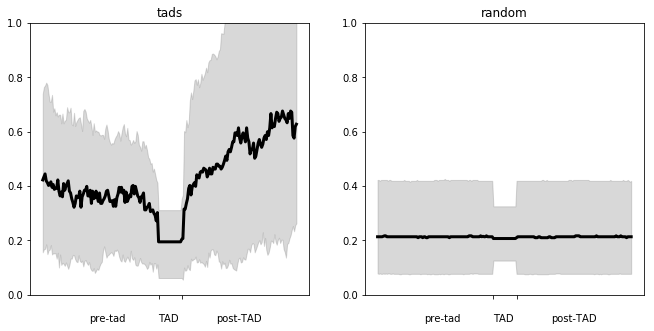

In [12]:
plt.figure(figsize=(11,5))
ax = plt.subplot(1,2,1)
plotit(ax,medians_dis_tad, _25_dis_tad, _75_dis_tad, 'tads')
plt.ylim(0,1)
ax = plt.subplot(1,2,2)
plotit(ax,medians_dis_random, _25_dis_random, _75_dis_random, 'random')
plt.ylim(0,1)